In [1]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import operator
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import load_iris

Reducing dimension of feature matrix with NMF.

In [2]:
# Function will run NMF on a given feature matrix and return a new matrix with desired dimensionality
def run_NMF(feat_mat,dim_out):
    model = NMF(n_components=dim_out,init='random', random_state=0)
    W = model.fit_transform(feat_mat)
    H = model.components_
    return W

The following are different methods that can be used to choose the number of clusters for certain algorithms.

In [3]:
# Function goal is to determine the right number of clusters for a given algorithm
# The clustering algorithm options are Kmeans and Agglomerative
# Runs algorithms with different numbers of clusters and calculates silhouette coefficient
# Returns the number of clusters that leads to the highest silhouette coefficient
def get_num_clust(feat_mat,alg):
    silhouettes = {}
    for k in range(2,11):
        if alg == 'agg':
            labels = clust_agg(feat_mat,k)
            avg_score = silhouette_score(feat_mat, labels)
            silhouettes[str(k)] = avg_score
        if alg == 'kmeans':
            (labels,centers) = clust_Kmeans(feat_mat,k)
            avg_score = silhouette_score(feat_mat, labels)
            silhouettes[str(k)] = avg_score
    num_clust = int(max(silhouettes.items(), key=operator.itemgetter(1))[0])
    return num_clust

In [4]:
# Function to estimate the bandwidth for MeanShift Clustering
def get_bw(feat_mat):
    bw = estimate_bandwidth(feat_mat)
    return bw

In [5]:
# For Gaussian Mixture Models
# Function calculates BIC for different numbers of clusters and different types of fits and returns resulting
# BIC array 
def get_bic(feat_mat):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 10)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
            gmm.fit(fm)
            bic.append(gmm.bic(fm))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    bic = np.array(bic)
    return bic

In [6]:
# For Gaussian Mixture Models
# Function calculates BIC for different numbers of clusters and different types of fits and returns resulting
# AIC array
def get_aic(feat_mat):
    lowest_aic = np.infty
    aic = []
    n_components_range = range(1, 10)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type)
            gmm.fit(fm)
            aic.append(gmm.aic(fm))
            if bic[-1] < lowest_aic:
                lowest_aic = aic[-1]
                best_gmm = gmm
    aic = np.array(aic)
    return aic

The following are different algorithms that can be used to cluster data given a feature matrix.

In [7]:
# Function runs K-means on a given feature matrix using a specified number of clusters
# Returns the feature matrix, the labels for each data point, and the cluster centers
def clust_Kmeans(feat_mat, num_clust):
    kmeans = KMeans(init='random', n_clusters=num_clust, n_init=100)
    kmeans.fit(feat_mat)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    return (labels, centers)

In [8]:
# Function runs Agglomerative Clustering on a given deature matrix using a specified number of clusters
# Retruns the label for each sample
def clust_agg(feat_mat, num_clust):
    labels = AgglomerativeClustering(n_clusters=num_clust).fit_predict(feat_mat)
    return labels

In [9]:
# Function runs MeanShift Clustering on a given feature matrix with a specified bandwidth parameters
# Returns the label for each sample
def clust_MS(feat_mat, bw):
    ms = MeanShift(bandwidth=bw).fit(feat_mat)
    labels = ms.labels_
    centers = ms.cluster_centers_
    return (labels, centers)

In [10]:
# Gaussian Mixture Model for a given feature matrix given number of components and covariance type
# Returns the labels for each sample
def gmm(feat_mat, num_clust, cov_type):
    gmm = mixture.GaussianMixture(n_components=num_clust, covariance_type=cov_type)
    labels = gmm.fit_predict(feat_mat)
    return labels

Next I'll demonstrate how these work on data. I will cluster some of the HBN data using a feature matrix made by teammates by age and by sex. I use ARI as a measurement of how well the algoritms performed.

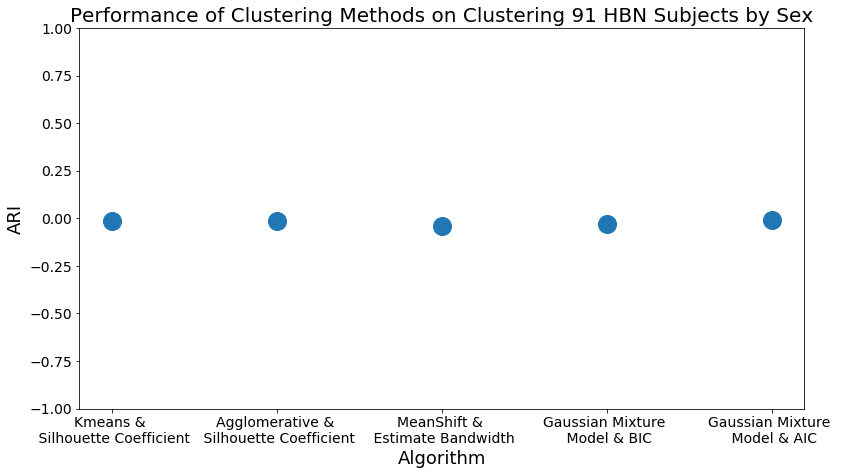

In [11]:
# The feature matrix here is one made of 288 vertex statistics by Vivek. I left in age as well, so there are
# 289 features total.

# Will look at sex first.

# Reading in Vivek's feature matrix
fm = np.genfromtxt('hbn_vertexstats.csv', delimiter=',')
fm = fm[1:,1:]

# Getting true labels
true_labels = np.zeros(91)
for i in range(0, fm.shape[0]):
    true_labels[i] = fm[i,0]
    
# Removing sex from the feature matrix
fm = fm[:,1:]

# Reducing dimensionality. I have chosen to reduce to 1/3 of the orignal number of fetures.
fm = run_NMF(fm, int(fm.shape[1]/3))

# Kmeans & Silhouette Score
numc_kmeans = get_num_clust(fm, 'kmeans')
(labels_kmeans, centers_kmeans) = clust_Kmeans(fm, numc_kmeans)
ari_kmeans = adjusted_rand_score(true_labels, labels_kmeans)

# Agglomerative Clustering & Silhouette Score
numc_agg = get_num_clust(fm, 'agg')
labels_agg = clust_agg(fm, numc_agg)
ari_agg = adjusted_rand_score(true_labels, labels_agg)

# MeanShift Clustering & Estimate Bandwidth
bw = get_bw(fm)
(labels_ms, centers_ms) = clust_MS(fm, bw)
ari_ms = adjusted_rand_score(true_labels, labels_ms)

# GMM and BIC
bic = get_bic(fm)
low_bc = np.argmin(bic)
# The lowest BIC score is for 2 components with full covariance type
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
labels_bic = gmm.fit_predict(fm)
ari_bic = adjusted_rand_score(true_labels, labels_bic)

# GMM and AIC
aic = get_aic(fm)
low_aic = np.argmin(aic)
# The lowest AIC score is for 5 components with full covariance type
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
labels_aic = gmm.fit_predict(fm)
ari_aic = adjusted_rand_score(true_labels, labels_aic)

# Will plot ARIs vs Algorithm here
plt.rcParams.update({"figure.figsize":(13, 7)})
plt.rcParams.update({"xtick.labelsize":14,"ytick.labelsize":14})
x = [0,1,2,3,4]
xTicks = ['Kmeans & \n Silhouette Coefficient','Agglomerative & \n Silhouette Coefficient',
         'MeanShift & \n Estimate Bandwidth', 'Gaussian Mixture \n Model & BIC', 'Gaussian Mixture \n Model & AIC']
y = [ari_kmeans, ari_agg, ari_ms, ari_bic, ari_aic]
plt.xticks(x, xTicks)
plt.xticks(range(5), xTicks)
plt.xlabel('Algorithm', fontsize=18)
plt.ylim(-1, 1)
plt.ylabel('ARI', fontsize=18)
plt.title('Performance of Clustering Methods on Clustering 91 HBN Subjects by Sex', fontsize=20)
plt.plot(x,y,'o',markersize=18)
plt.show()

The age median is:
10.044261


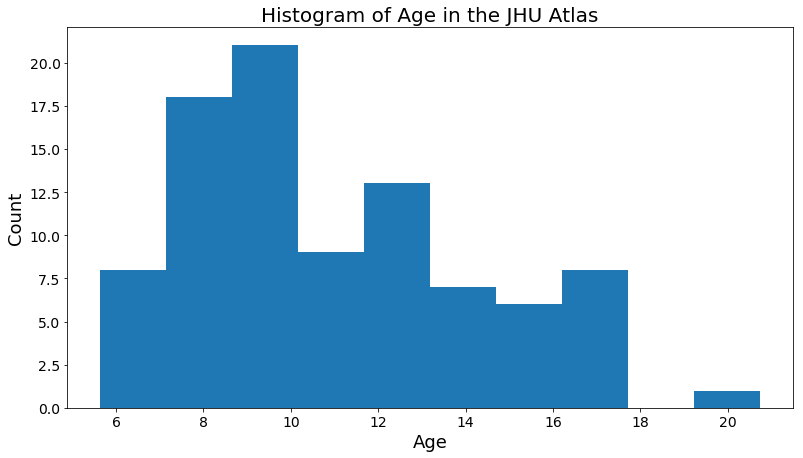

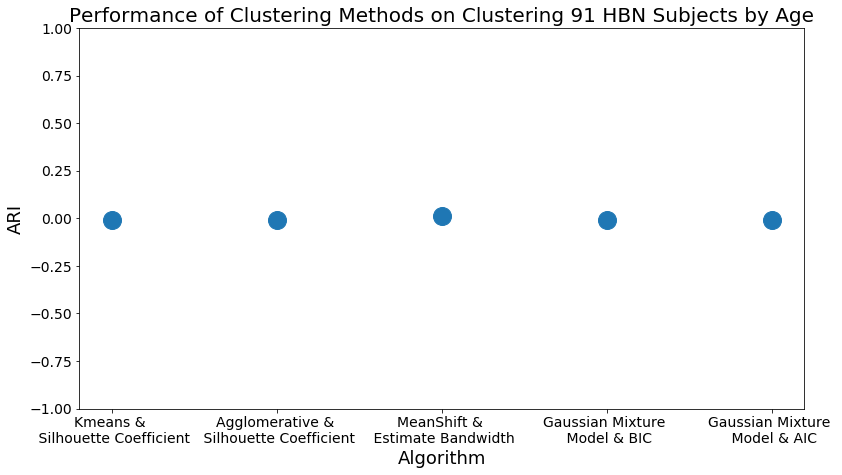

In [12]:
# Now looking at the same matrix, clustering for age.

# Reading in feature matrix
fm = np.genfromtxt('hbn_vertexstats.csv', delimiter=',')
fm = fm[1:,1:]

# Determining the median of age
age = fm[:,1]
print("The age median is:")
print(np.median(age))

# Plotting a histogram of age
plt.hist(age)
plt.title('Histogram of Age in the JHU Atlas',fontsize=20)
plt.xlabel('Age',fontsize=18)
plt.ylabel('Count',fontsize=18)

# Creating labels for age. Age <=10 will be one group, and >10 another group. Since 10 years is the median.
true_labels = np.zeros(91)
for i in range(fm.shape[0]):
    if age[i] > 10:
        true_labels[i] = 1

# Removing sex and age from the feature matrix
fm = fm[:,2:]

# Reducing dimensionality. I have chosen to reduce to 1/3 of the orignal number of fetures.
fm = run_NMF(fm, int(fm.shape[1]/3))

# Kmeans & Silhouette Score
numc_kmeans = get_num_clust(fm, 'kmeans')
(labels_kmeans, centers_kmeans) = clust_Kmeans(fm, numc_kmeans)
ari_kmeans = adjusted_rand_score(true_labels, labels_kmeans)

# Agglomerative Clustering & Silhouette Score
numc_agg = get_num_clust(fm, 'agg')
labels_agg = clust_agg(fm, numc_agg)
ari_agg = adjusted_rand_score(true_labels, labels_agg)

# MeanShift Clustering & Estimate Bandwidth
bw = get_bw(fm)
(labels_ms, centers_ms) = clust_MS(fm, bw)
ari_ms = adjusted_rand_score(true_labels, labels_ms)

# GMM and BIC
bic = get_bic(fm)
low_bc = np.argmin(bic)
# The lowest BIC score is for 2 components with full covariance type
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
labels_bic = gmm.fit_predict(fm)
ari_bic = adjusted_rand_score(true_labels, labels_bic)

# GMM and AIC
aic = get_aic(fm)
low_aic = np.argmin(aic)
# The lowest AIC score is for 5 components with full covariance type
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
labels_aic = gmm.fit_predict(fm)
ari_aic = adjusted_rand_score(true_labels, labels_aic)

# Will plot ARIs vs Algorithm here
plt.figure()
plt.rcParams.update({"figure.figsize":(13, 7)})
plt.rcParams.update({"xtick.labelsize":14,"ytick.labelsize":14})
x = [0,1,2,3,4]
xTicks = ['Kmeans & \n Silhouette Coefficient','Agglomerative & \n Silhouette Coefficient',
         'MeanShift & \n Estimate Bandwidth', 'Gaussian Mixture \n Model & BIC', 'Gaussian Mixture \n Model & AIC']
y = [ari_kmeans, ari_agg, ari_ms, ari_bic, ari_aic]
plt.xticks(x, xTicks)
plt.xticks(range(5), xTicks)
plt.xlabel('Algorithm', fontsize=18)
plt.ylim(-1, 1)
plt.ylabel('ARI', fontsize=18)
plt.title('Performance of Clustering Methods on Clustering 91 HBN Subjects by Age', fontsize=20)
plt.plot(x,y,'o',markersize=18)
plt.show()

As you can see, the algorithms aren't performing well to cluster age and sex. To be continued in Sprint 2!

Next I'll show that the silhouette coefficient makes sense to use even when switching them number of dimensions. In 1D, if you have the points -1, 0, and 1, the average silhouette score is the same as if you have the points (-1, 0), (0, 0), and (1, 0) in 2D or (-1, 0, 0), (0, 0, 0), and (1, 0 ,0) in 3D. Similarly, it is the same as if you have the points (-1, -1), (0, 0), and (1, 1) in 2D or (-1, -1, -1), (0, 0, 0), and (1, 1, 1) in 3D. This shows that changing the number of dimensions does not invalidate using the silhouette score.

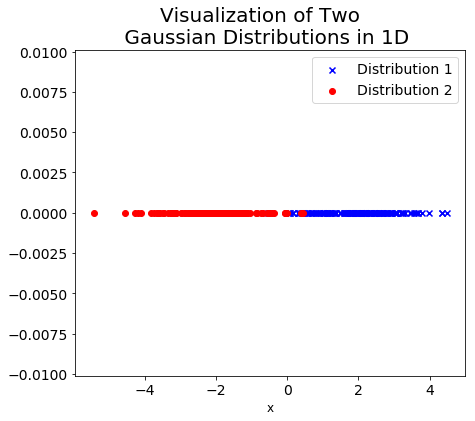

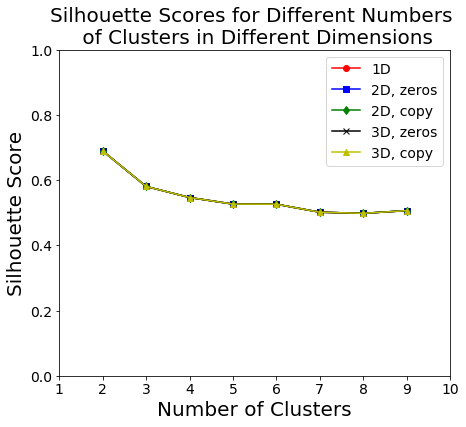

In [13]:
# Silhouette experiment

# Formatting figure
plt.rcParams.update({"figure.figsize":(7, 6)})
plt.rcParams.update({"xtick.labelsize":14,"ytick.labelsize":14})

mean1 = 2
mean2 = -mean1

# Making first 1D Gaussian and plotting
mean = mean1
var = 1
a = np.random.normal(mean, var, 150).T
fig = plt.figure()
c1 = plt.scatter(a,np.zeros(150),c='b',marker='x')
fig.suptitle("Visualization of Two \n Gaussian Distributions in 1D", fontsize=20)

# Making second 1D Gaussian and plotting
mean = mean2
var = 1
x = np.random.normal(mean, var, 150).T
c2 = plt.scatter(x,np.zeros(150),c='r',marker='o')

plt.legend([c1, c2], ['Distribution 1', 'Distribution 2'], fontsize=14)
plt.xlabel('x',fontsize=12)

# Making a feature matrix from the distributions
c = np.concatenate([[a, x]]).reshape(1,300)
fm = np.concatenate([c]).transpose()

# Determining silhouette score for 2-9 clusters in 1D
silhouettes = np.empty([6, 8])
for k in range(2, 10):
    labels = clust_agg(fm, k)
    silhouettes[0,k-2] = silhouette_score(fm, labels)
    
# Moving to 2D, zeros
fm = np.concatenate([c,np.zeros((1,300))]).transpose()
for k in range(2, 10):
    labels = clust_agg(fm, k)
    silhouettes[1,k-2] = silhouette_score(fm, labels)
    
# Moving to 2D, copy
fm = np.concatenate([c,c]).transpose()
for k in range(2, 10):
    labels = clust_agg(fm, k)
    silhouettes[2,k-2] = silhouette_score(fm, labels)
    
# Moving to 3D, zeros
fm = np.concatenate([c,np.zeros((1,300)),np.zeros((1,300))]).transpose()
for k in range(2, 10):
    labels = clust_agg(fm, k)
    silhouettes[3,k-2] = silhouette_score(fm, labels)
    
# Moving to 3D, copy
fm = np.concatenate([c,c,c]).transpose()
for k in range(2, 10):
    labels = clust_agg(fm, k)
    silhouettes[4,k-2] = silhouette_score(fm, labels)
    

# Plotting silhouette scores
plt.figure()
plt.plot([2,3,4,5,6,7,8,9], silhouettes[0,:], 'ro', label='1D', ls='-')
plt.plot([2,3,4,5,6,7,8,9], silhouettes[1,:], 'bs', label='2D, zeros', ls='-')
plt.plot([2,3,4,5,6,7,8,9], silhouettes[2,:], 'gd', label='2D, copy', ls='-')
plt.plot([2,3,4,5,6,7,8,9], silhouettes[3,:], 'kx', label='3D, zeros', ls='-')
plt.plot([2,3,4,5,6,7,8,9], silhouettes[4,:], 'y^', label='3D, copy', ls='-')
plt.axis([1, 10, 0, 1])
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylabel('Silhouette Score', fontsize=20)
plt.legend(fontsize=14)
plt.title('Silhouette Scores for Different Numbers \n of Clusters in Different Dimensions', fontsize=20)
plt.show()